In [1]:
# Set autoreload
%load_ext autoreload
%autoreload 2

# AthenaDataSets - Preparando datasets via Athena

---------------
- Objetivo: Acelerar carregamento de datasets via Athena para experimentação
-----------------------------------

- Algumas informações foram ocultas por questões legais 
- Some information were hided for legal reasons

## 0. Instalar a biblioteca legal nlp

In [2]:
import pkg_resources
from getpass import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


In [3]:
#!pip install gensim==3.8.3

In [4]:
#!pip install scikit-learn

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import spacy
nlp_ = spacy.load('pt_core_news_sm', disable = ['ner', 'tagger', 'parser'])
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## 2. Importar o módulo `AthenaDatasets`

In [6]:
ad = AthenaDatasets(profile_name=PROFILE_NAME)

2022-10-20 17:39:37,608 - [INFO] - lexter_nlp.storage.resources - (resources.py).__init__(27) - Creating folder /root/lexter/lexter.nlp.ds.resources to mirror s3 bucket lexter.nlp.ds.resources


## 3. Usar o módulo!

### `training_data`

Obter documentos, smart_fields e anotações para treinamento

# 3. Paragrafos anotados

In [8]:
df_parags = data1['parag_df']
df_anns = data1['anns_df']

In [9]:
ultima_versao_etl = df_parags['etl_version'].max()
df_parag_plot = df_parags[df_parags['etl_version'] == ultima_versao_etl]

In [10]:
ultima_versao_etl = df_parags['etl_version'].max()
df_parag_plot = df_parags[df_parags['etl_version'] == ultima_versao_etl]

# 4.Analisando o df_parags a partir de embeddings

In [121]:
from nltk.tokenize import regexp_tokenize
from nltk import ngrams
import unidecode
from itertools import chain, combinations

In [122]:
df_parags_pp = df_parags[df_parags['page_part']=='body']

In [123]:
df_parags_ = df_parags_pp[['document_id', 'paragraph_id', 'page_id', 'page_part_id', 'n_tokens', 'section_id', 'section_title', 'annotated','text', 'start_index', 'end_index']]
df_parags_['len_sectitle_tokens'] = df_parags_.section_title.apply(lambda x:len(x.split(" ")))

/tmp/ipykernel_303/514374135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parags_['len_sectitle_tokens'] = df_parags_.section_title.apply(lambda x:len(x.split(" ")))


In [124]:
df_anns = data1['anns_df']

In [125]:
df_golden_anns = df_anns[['document_id', 'smart_field_id', 'start_index', 'end_index']]

In [126]:
def df_to_ltuples(df):
   
    df_ = df[['document_id','paragraph_id','page_id', 'page_part_id', 'section_id', 'annotated', 'section_title', 'text']]
    l_paragraph_tuples = list(df_.to_records(index=False))
    l_paragraph_tuples = list(map(lambda x:(str(x[0])+ "__" + str(x[1])+ "__" +str(x[2])+
                                            "__" +str(x[3])+ "__" +str(x[4])+
                                            "__" +str(x[5]), x[6], x[7]), l_paragraph_tuples))
    return l_paragraph_tuples
    

In [127]:
def tokenize_parags (l_parags, n=1):
    l_parags_norm = list(map(lambda x: unidecode.unidecode(x.lower()), l_parags))
    pattern = r"[a-zA-Z]+"
    l_parags_tok = list(map(lambda x: regexp_tokenize(x, pattern), l_parags_norm))
    l_parags_tok = list(map(lambda x: list(filter(lambda y:len(y)>2,x)), l_parags_tok))
    if (n>=2):
        l_parags_tok = list(map(lambda x: ["_".join(grams) for grams in ngrams(x, n)], l_parags_tok))
    return l_parags_tok

def tokenize_parags_f(l_par_tuples, n=1):
    l_parags_ids = list(map(lambda x:x[0], l_par_tuples))
    l_parags_toks  = list(map(lambda x:x[2], l_par_tuples))
    l_section_toks  = list(map(lambda x:x[1], l_par_tuples))
    l_parags_toks = tokenize_parags(l_parags_toks, n=n)
    l_section_toks = tokenize_parags(l_section_toks, n=n)
    l_section_parag_toks = list(zip(l_section_toks, l_parags_toks))
    l_section_parag_toks = list(map(lambda x: x[0]+x[1],l_section_parag_toks))
    return  l_parags_ids, l_section_toks, l_parags_toks, l_section_parag_toks

In [128]:
def train_parg2vec_model (l_parags_ids, l_parags_toks, max_epochs = 70, vec_size=250, alpha =0.025, model_name= "d2v.model"):
    tagged_parags = [TaggedDocument(words=parag_toks, tags=[l_parags_ids[i]]) for i, parag_toks in enumerate(l_parags_toks)]
    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=5,
                    dm =1,
                    epochs = max_epochs)
    model.build_vocab(tagged_parags)
    model.train(tagged_parags,
                total_examples=model.corpus_count,
                epochs=model.epochs)

    model.save(model_name)
    print("Model Saved")
    return (tagged_parags, model_name)


In [129]:
def calc_extreme_topwords(ltoksids, 
                          lparagtoks, 
                          sementes_quesito = ['direito'],
                          contextos_quesito = ['preferencia']  
                         ):
    ids_toks = list(zip(ltoksids, lparagtoks))
    
    true_toks = list(filter(lambda x:'True' in x[0],ids_toks))
    false_toks = list(filter(lambda x:'False' in x[0],ids_toks))
    
    true_toks = list(map(lambda y:y[1], true_toks))
    false_toks = list(map(lambda y:y[1], false_toks))
    
    docfreq_trues = Counter()
    docfreq_falses = Counter()
    
    for p in true_toks:
        intersect_sementes_quesito = list(set(p).intersection(set(sementes_quesito)))
        intersect_sementes_contextquesito = list(set(p).intersection(set(contextos_quesito)))
        if (len(intersect_sementes_quesito)>0 and len(intersect_sementes_contextquesito)>0):
            docfreq_trues += Counter(list(set(p)))
        
    for p in false_toks:
        docfreq_falses += Counter(list(set(p)))
        
    l_tuple_tok_weight = []
    l_tuple_tok_weight_ = []
    
    for tok in docfreq_trues:
        if (tok in docfreq_falses):
            tfidfonfalse = docfreq_trues[tok] *(1/docfreq_falses[tok])
            l_tuple_tok_weight.append((tok, tfidfonfalse))
        else:
            l_tuple_tok_weight.append((tok, docfreq_trues[tok]))
  
    l_tuple_tok_weight.sort(key =lambda x:x[1], reverse = True)
    
        
    n_topwords = int(0.2*len(l_tuple_tok_weight))
    l_tuple_tok_weight = l_tuple_tok_weight[:n_topwords]
    
    l_tuple_tok_weight = list(map(lambda x:x[0], l_tuple_tok_weight))
    
   
    return l_tuple_tok_weight

In [130]:
def calc_extreme_top_bigrams(ltoksids, 
                             lparagtoks,
                             sementes_quesito = ['direito'],
                             contextos_quesito = ['preferencia']):
    
    ids_toks = list(zip(ltoksids, lparagtoks))
    
    true_toks = list(filter(lambda x:'True' in x[0],ids_toks))
    false_toks = list(filter(lambda x:'False' in x[0],ids_toks))
    
    true_toks = list(map(lambda y:y[1], true_toks))
    false_toks = list(map(lambda y:y[1], false_toks))

    docfreq_trues = Counter()
    docfreq_falses = Counter()
    
    # Calculamos bigramas
    b_true_toks = []
    b_false_toks = []
    
    for p in true_toks:
        intersect_sementes_quesito = list(set(p).intersection(set(sementes_quesito)))
        intersect_sementes_contextquesito = list(set(p).intersection(set(contextos_quesito)))
        if (len(intersect_sementes_quesito)>0 and len(intersect_sementes_contextquesito)>0):
            b_true_toks.append(list(map(lambda x: " ".join(x),list(ngrams(p,2)))))
    
    for p in false_toks:
        b_false_toks.append(list(map(lambda x: " ".join(x),list(ngrams(p,2)))))
    
    for p in b_true_toks:                 
        #i_counter_trues += Counter(p)
        docfreq_trues += Counter(list(set(p)))
        
    for p in b_false_toks:
        #i_counter_falses += Counter(p)
        docfreq_falses += Counter(list(set(p)))
        
        
    l_tuple_tok_weight = []
    
    
    for tok in docfreq_trues:
        if (tok in docfreq_falses):
            tfidfonfalse = docfreq_trues[tok] *(1/docfreq_falses[tok])
            l_tuple_tok_weight.append((tok, tfidfonfalse))
        else:
            l_tuple_tok_weight.append((tok, docfreq_trues[tok]))
  
    l_tuple_tok_weight.sort(key =lambda x:x[1], reverse = True)
    
    
    n_topwords = int(0.2*len(l_tuple_tok_weight))
    
    l_tuple_tok_weight = list(map(lambda x:x[0], l_tuple_tok_weight))
   
    
    l_tuple_tok_weight  = l_tuple_tok_weight[:n_topwords]
    

    return l_tuple_tok_weight

In [131]:
def calc_topwords_smartfield(ltoksids, lparagtoks):
    ids_toks = list(zip(ltoksids, lparagtoks))
    
    true_toks = list(filter(lambda x:'True' in x[0],ids_toks))
    false_toks = list(filter(lambda x:'False' in x[0],ids_toks))
    
    true_toks = list(map(lambda y:y[1], true_toks))
    false_toks = list(map(lambda y:y[1], false_toks))
    
    i_counter_trues = Counter()
    i_counter_falses = Counter()
    docfreq_falses = Counter()
    
    for p in true_toks:
        i_counter_trues += Counter(p)
        
    for p in false_toks:
        i_counter_falses += Counter(p)
        docfreq_falses += Counter(list(set(p)))
        
    l_tuple_tok_weight = []
    
    for tok in i_counter_trues:
        if  (tok in i_counter_falses):
            tfidfonfalse = i_counter_trues[tok] *(1/i_counter_falses[tok]*(1/docfreq_falses[tok]))
            l_tuple_tok_weight.append((tok, tfidfonfalse))
        else:
            l_tuple_tok_weight.append((tok, i_counter_trues[tok]))
    
    l_tuple_tok_weight.sort(key =lambda x:x[1], reverse = True)
    n_topwords = int(0.25*len(l_tuple_tok_weight))
    l_tuple_tok_weight  = l_tuple_tok_weight[:n_topwords]
    
    return list(map(lambda x:x[0], l_tuple_tok_weight))

In [132]:
def calc_topwords_smartfield1(ltoksids, lparagtoks):
    ids_toks = list(zip(ltoksids, lparagtoks))
    
    true_toks = list(filter(lambda x:'True' in x[0],ids_toks))
    false_toks = list(filter(lambda x:'False' in x[0],ids_toks))
    
    true_toks = list(map(lambda y:y[1], true_toks))
    false_toks = list(map(lambda y:y[1], false_toks))
    
    docfreq_trues = Counter()
    docfreq_falses = Counter()
    
    for p in true_toks:
        docfreq_trues += Counter(list(set(p)))
        
    for p in false_toks:
        docfreq_falses += Counter(list(set(p)))
        
    l_tuple_tok_weight = []
    l_tuple_tok_weight_ = []
    
    for tok in docfreq_trues:
        if  (tok in docfreq_falses):
            tfidfonfalse = docfreq_trues[tok] *(1/docfreq_falses[tok])
            l_tuple_tok_weight.append((tok, tfidfonfalse))
        else:
            l_tuple_tok_weight.append((tok, docfreq_trues[tok]))
            
    for tok in docfreq_falses:
        if  (tok in docfreq_trues):
            tfidfontrue = docfreq_falses[tok] *(1/docfreq_trues[tok])
            l_tuple_tok_weight_.append((tok, tfidfontrue))
        else:
            l_tuple_tok_weight_.append((tok, docfreq_falses[tok]))
    
    l_tuple_tok_weight.sort(key =lambda x:x[1], reverse = True)
    l_tuple_tok_weight_.sort(key =lambda x:x[1], reverse = True)
        
    n_topwords = int(0.2*len(l_tuple_tok_weight))
    n_topwords_falses = int(0.2*len(l_tuple_tok_weight_))

    l_tuple_tok_weight  = l_tuple_tok_weight[:n_topwords] 
    l_tuple_tok_weight_ = l_tuple_tok_weight_[:n_topwords_falses]
    
    l_tuple_tok_weight = list(map(lambda x:x[0], l_tuple_tok_weight))
    l_tuple_tok_weight_ = list(map(lambda x:x[0], l_tuple_tok_weight_))
    
    l_tuple_tok_weight = list(set(l_tuple_tok_weight) - set(l_tuple_tok_weight_))
    
    return l_tuple_tok_weight
    
    #return list(map(lambda x:x[0], l_tuple_tok_weight))

In [133]:
def calc_topbigrams_smartfield(ltoksids, lparagtoks):
    
    ids_toks = list(zip(ltoksids, lparagtoks))
    
    true_toks = list(filter(lambda x:'True' in x[0],ids_toks))
    false_toks = list(filter(lambda x:'False' in x[0],ids_toks))
    
    true_toks = list(map(lambda y:y[1], true_toks))
    false_toks = list(map(lambda y:y[1], false_toks))

    docfreq_trues = Counter()
    docfreq_falses = Counter()
    
    # Calculamos bigramas
    b_true_toks = []
    b_false_toks = []
    
    for p in true_toks:
        b_true_toks.append(list(map(lambda x: " ".join(x),list(ngrams(p,2)))))
    
    for p in false_toks:
        b_false_toks.append(list(map(lambda x: " ".join(x),list(ngrams(p,2)))))
    
    for p in b_true_toks:                 
        #i_counter_trues += Counter(p)
        docfreq_trues += Counter(list(set(p)))
        
    for p in b_false_toks:
        #i_counter_falses += Counter(p)
        docfreq_falses += Counter(list(set(p)))
        
    l_tuple_tok_weight = []
    l_tuple_tok_weight_ = []
    
    for tok in docfreq_trues:
        if  (tok in docfreq_falses):
            tfidfonfalse = docfreq_trues[tok] *(1/docfreq_falses[tok])
            l_tuple_tok_weight.append((tok, tfidfonfalse))
        else:
            l_tuple_tok_weight.append((tok, docfreq_trues[tok]))
            
    for tok in docfreq_falses:
        if  (tok in docfreq_trues):
            tfidfontrue = docfreq_falses[tok] *(1/docfreq_trues[tok])
            l_tuple_tok_weight_.append((tok, tfidfontrue))
        else:
            l_tuple_tok_weight_.append((tok, docfreq_falses[tok]))
    
    l_tuple_tok_weight.sort(key =lambda x:x[1], reverse = True)
    l_tuple_tok_weight_.sort(key =lambda x:x[1], reverse = True)
    
    n_topwords = int(0.25*len(l_tuple_tok_weight))
    n_topwords_falses = int(0.2*len(l_tuple_tok_weight_))
    
    l_tuple_tok_weight  = l_tuple_tok_weight[:n_topwords]
    l_tuple_tok_weight_ = l_tuple_tok_weight_[:n_topwords_falses]
    
    l_tuple_tok_weight = list(map(lambda x:x[0], l_tuple_tok_weight))
    l_tuple_tok_weight_ = list(map(lambda x:x[0], l_tuple_tok_weight_))
    
    l_tuple_tok_weight = list(set(l_tuple_tok_weight) - set(l_tuple_tok_weight_))
    
    return l_tuple_tok_weight
    
    #return list(map(lambda x:x[0], l_tuple_tok_weight))

In [134]:
def get_similarity_based_prediction (test_parag_vec, p2vmodel, top =15):
    inferred_vector = p2vmodel.infer_vector(test_parag_vec)
    sims = p2vmodel.docvecs.most_similar([inferred_vector], topn=top)
    vec_trues = list(filter(lambda x:'True' in x[0], sims))
    vec_falses = list(filter(lambda x:'False' in x[0], sims))
    size_trues = len(vec_trues)
    size_falses = len(vec_falses)
    if (size_trues > size_falses):
        return "True"
    return "False"

In [135]:
def get_similarity_based_prediction2 (l_test_section_title, 
                                      l_test_parag_vec,
                                      l_parags_topw,
                                      l_parags_topw_unique,
                                      l_parags_topbigr,
                                      l_parags_topbigr_unique, 
                                      p2vmodelParag, 
                                      p2vmodelTitle, top =15):
    
    inferred_vectors_parag = list(map(lambda x: p2vmodelParag.infer_vector(x), l_test_parag_vec))
    inferred_vectors_secttitle = list(map(lambda x: p2vmodelTitle.infer_vector(x), l_test_section_title))
    
    sims_parags = list(map(lambda x:p2vmodelParag.docvecs.most_similar(x, topn=top), inferred_vectors_parag))
    sims_title =  list(map(lambda x:p2vmodelTitle.docvecs.most_similar(x, topn=top), inferred_vectors_secttitle))
    
    parag_vecs_trues = map(lambda x: list(filter(lambda x:'True' in x[0], x)) , sims_parags)
    parag_vecs_falses = map(lambda x: list(filter(lambda x:'False' in x[0], x)) , sims_parags)
    
    title_vecs_trues = list(map(lambda x: list(filter(lambda x:'True' in x[0], x)) , sims_title))
    title_vecs_falses = list(map(lambda x: list(filter(lambda x:'False' in x[0], x)) , sims_title))

    
    sizes_parags_trues  = list(map(lambda x:len(x), parag_vecs_trues))
    sizes_parags_falses  = list(map(lambda x:len(x), parag_vecs_falses))
    
    sizes_titles_trues  = list(map(lambda x:len(x), title_vecs_trues))
    sizes_titles_falses  = list(map(lambda x:len(x), title_vecs_falses))

    predictions = []
    predictions_on_parag = []
    predictions_on_title = []
    predictions_on_tw = []
    
    
    
    for i in range (len(sizes_titles_trues)):
        '''
        if((sizes_parags_trues[i] > sizes_parags_falses[i]) or 
           (sizes_titles_trues[i] > sizes_titles_falses[i]) or 
           (l_parags_topw[i] >= 2) or 
           (l_parags_topw_unique[i] >= 1) or
           (l_parags_topbigr[i] >= 1) or
           (l_parags_topbigr_unique[i] >= 1)):
        
        if((l_parags_topw[i] >= 2) or 
           (l_parags_topw_unique[i] >= 2) or
           (l_parags_topbigr[i] >= 1) or
           (l_parags_topbigr_unique[i] >= 1)):
        '''
        if((l_parags_topbigr[i] >= 2) or
           (l_parags_topbigr_unique[i] >= 2)):
                
            predictions.append(True)
            '''
            if (sizes_parags_trues[i] > sizes_parags_falses[i]):
                predictions_on_parag.append(True)
            else:
                predictions_on_parag.append(False)
                
            if (sizes_titles_trues[i] > sizes_titles_falses[i]):
                predictions_on_title.append(True)
            else:
                predictions_on_title.append(False)
               
            if (l_parags_topw[i] >= 0.1):
                predictions_on_tw.append(True)
            else:
                predictions_on_tw.append(False)
            if (l_parags_topw[i] >= 0.1):
                predictions_on_tw.append(True)
            else:
                predictions_on_tw.append(False)
            '''    
                
            
        else:
            predictions.append(False)
            #predictions_on_parag.append(False)
            #predictions_on_title.append(False)
            #predictions_on_tw.append(False)
        
    return predictions
    #return predictions, predictions_on_parag, predictions_on_title, predictions_on_tw

In [136]:
def cosinesim_based_prediction_mixedfeat(df_train, l_parag_toks ,model_embbParag, top =15):
    p2vec_feat = list(map(lambda x: model_embbParag.infer_vector(x), l_parag_toks))
    mixed_feat = list(zip(p2vec_feat, df_train['Perc_topwords'].tolist()))
    mixed_feat = list(map(lambda x: (list(x[0]), x[1]), mixed_feat))
    mixed_feat = list(map(lambda x: x[0]+ [x[1]], mixed_feat))
    
   
    cosine_sim = cosine_similarity(mixed_feat, mixed_feat)
    index_pairs = [list(df_train.index)]*cosine_sim.shape[0]
    
    # PREDICTING
    df_train['prediction_mixed_feat_cosinesim'] = False
    for i in range(len(index_pairs)):
        similars  = sorted(list(zip(index_pairs[i], cosine_sim[i])), key = lambda x:x[1], reverse = True)[:top]
        similars = list(map(lambda x:x[0], similars))
        class_similars =df_train.iloc[similars]['annotated'].tolist()
        class_similars_cnts = Counter(class_similars)
        if (class_similars_cnts[True]>= class_similars_cnts[False]):
            idx_loc_score = index_pairs[i][i]
            df_train.iloc[idx_loc_score, df_train.columns.get_loc('prediction_tfidfsim')] = True
          
    return df_train

In [137]:
def prediction_smf (lsectionparagtoks, p2vmodel, top = 15):
    vec_predictions = []
    for i in lsectionparagtoks:
        pred = get_similarity_based_prediction(i, p2vmodel, top=top)
        vec_predictions.append(pred)
    return vec_predictions

In [138]:
def calc_top_skipgrams_smartfield(ltoksids, lparagtoks, n=2):
    ids_toks = list(zip(ltoksids, lparagtoks))
    
    true_toks = list(filter(lambda x:'True' in x[0],ids_toks))
    false_toks = list(filter(lambda x:'False' in x[0],ids_toks))
    
    true_toks = list(map(lambda y:y[1], true_toks))
    false_toks = list(map(lambda y:y[1], false_toks))
    
    docfreq_trues = Counter()
    docfreq_falses = Counter()
    
    for p in true_toks:
        unique_skipgrams = list(set(list(map(lambda x:x,list(combinations(p,2))))))
        docfreq_trues += Counter(unique_skipgrams)
                                
    for p in false_toks:
        unique_skipgrams = list(set(list(map(lambda x:x,list(combinations(p,2))))))
        docfreq_falses += Counter(unique_skipgrams)
                                
    l_tuple_tok_weight = []
    
    for skipg in docfreq_trues:
        if  (skipg in docfreq_falses):
            tfidfonfalse = docfreq_trues[skipg] *(1/docfreq_falses[skipg])
            l_tuple_tok_weight.append((skipg, tfidfonfalse))
        else:
            l_tuple_tok_weight.append((skipg, docfreq_trues[skipg]))
    
    l_tuple_tok_weight.sort(key =lambda x:x[1], reverse = True)
    n_topwords = int(0.25*len(l_tuple_tok_weight))
    l_tuple_tok_weight  = l_tuple_tok_weight[:n_topwords]  
    return list(map(lambda x:x[0], l_tuple_tok_weight))

In [139]:
def cal_features_topwords (lsectiontoks, ltopwordstrue, n_extr = 20):
    features = []
    for p in lsectiontoks:
        topwords = list(filter(lambda x:x in ltopwordstrue, p))
        extreme_tw = list(filter(lambda x:x in ltopwordstrue[:n_extr], p))
        if (len(p) == 0):
            perc_top_words = 0.0
            perc_unique_topwords = 0.0
        else:
            perc_top_words = len(topwords)/len(p)
            perc_unique_topwords = len(list(set(topwords)))/len(p)
        
        features.append((len(topwords), len(list(set(topwords))), perc_top_words, perc_unique_topwords, topwords, len(extreme_tw)))
    return features
    

In [140]:
def cal_features_topbigrams (lsectiontoks, ltopbigramstrue, n_extr = 20):
    features = []
    for p in lsectiontoks:
        bigrams_ = list(map(lambda x: " ".join(x),list(ngrams(p,2))))
        topbigrams = list(filter(lambda x: x in ltopbigramstrue, bigrams_))
        extreme_top_bigr = list(filter(lambda x: x in ltopbigramstrue[:n_extr], bigrams_))
        if (len(bigrams_) == 0):
            perc_top_words = 0.0
            perc_unique_topwords = 0.0
        else:
            perc_top_words = len(topbigrams)/len(bigrams_)
            perc_unique_topwords = len(list(set(topbigrams)))/len(bigrams_)
        features.append((len(topbigrams), len(list(set(topbigrams))), perc_top_words, perc_unique_topwords, topbigrams, len(extreme_top_bigr)))
    return features

In [141]:
def cal_features_skipgrams (lsectiontoks, ltopskipgramstrue):
    features = []
    for p in lsectiontoks:
        skipgrams_ = list(set(list(map(lambda x:x,list(combinations(p,2))))))
        topskipgrams_ = list(filter(lambda x: x in ltopskipgramstrue, skipgrams_))
        if (len(skipgrams_) == 0):
            perc_top_words = 0.0
            perc_unique_topwords = 0.0
        else:
            perc_top_words = len(topskipgrams_)/len(skipgrams_)
            perc_unique_topwords = len(list(set(topskipgrams_)))/len(skipgrams_)
        
        features.append((len(topskipgrams_), len(list(set(topskipgrams_))), perc_top_words, perc_unique_topwords))
    return features

In [142]:
def find_stopw_1 (lparagstoks, nperc = 0.0035, ngram = 1):
    
    i_counter = Counter()
    
    for p in lparagstoks:
        i_counter += Counter(p)
    n = int(nperc*len(i_counter.items()))
    l_i_counter = sorted(i_counter.items(), key= lambda x:x[1],  reverse = True)
    automatic_sw = l_i_counter[:n]
    automatic_sw = list(map(lambda x:x[0], automatic_sw))
   
    
    return automatic_sw

In [143]:
def remove_stopwords1 (lparagstoks, ltitletoks, lstopwords):
    
    lstopwords_ = " ".join(lstopwords)
    
    new_paragstoks=[]
    for p in lparagstoks:
        new_paragstoks.append(list(filter(lambda x:lstopwords_.find(x)==-1 , p)))
        
    new_titlestoks=[]
    for p in ltitletoks:
        new_titlestoks.append(list(filter(lambda x:lstopwords_.find(x)==-1 , p)))
        
    return new_paragstoks, new_titlestoks 

In [144]:
def lemmatize(ltuples):
    
    new_tuples = []
    for t in ltuples:
        new_str_title  = " ".join([token.lemma_ for token in nlp_(t[1])])
        new_str_parag = " ".join([token.lemma_ for token in nlp_(t[2])])
        new_tuples.append((t[0], new_str_title,  new_str_parag))
 
    return new_tuples 

In [145]:
def stemming(ltuples):
    stemmer = nltk.stem.RSLPStemmer()
    new_tuples = []
    for t in ltuples:
        new_str_title  = " ".join([stemmer.stem(token) for token in t[1].split()])
        new_str_parag = " ".join([stemmer.stem(token) for token in t[2].split()])
        new_tuples.append((t[0], new_str_title,  new_str_parag))
 
    return new_tuples 

In [146]:
def evaluation_metrics1 (df, col_ann='annotated', col_pred= 'prediction'):
  
    df['TruePositive'] = df.apply(lambda x: 1 if ((x[col_ann] == True) and ((x[col_pred] == True))) else 0, axis =1)
    df['TrueNegatives'] = df.apply(lambda x: 1 if ((x[col_ann] == False) and ((x[col_pred] == False))) else 0, axis =1)
    df['FalsePositives'] = df.apply(lambda x: 1 if ((x[col_ann] == False) and ((x[col_pred] == True))) else 0, axis =1)
    df['FalseNegatives'] = df.apply(lambda x: 1 if ((x[col_ann] == True) and ((x[col_pred] == False))) else 0, axis =1)
    df['cont_annotated'] = df.apply(lambda x: 1 if (x[col_ann] == True) else 0, axis =1)
    
    tot_truepositives, tot_truenegatives, tot_falsepositives, tot_falsenegatives, tot_annotated_true = df[['TruePositive', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'cont_annotated']].sum()
    recall = tot_truepositives/(tot_truepositives + tot_falsenegatives)
    precision = tot_truepositives/(tot_truepositives + tot_falsepositives)
    f_measure = (2*precision*recall)/precision + recall
    accuracy = (tot_truepositives + tot_truenegatives)/ (tot_truepositives + tot_truenegatives + tot_falsepositives + tot_falsenegatives)
    precisao_trues = tot_truepositives/tot_annotated_true
    
    return precision, recall, f_measure, accuracy, precisao_trues

In [147]:
def get_faixas_eval_simples (row, metric = 'precision'):
    
    if ((metric == 'precision') and (row[metric]<=0.5)):
        return 'pr_<=50%'
    elif ((metric == 'precision') and (row[metric]>0.5)):
        return 'pr_>50%'
    elif ((metric == 'recall') and (row[metric]<=0.5)):
        return 'rec_<=50%'
    elif ((metric == 'recall') and (row[metric]>0.5)):
        return 'rec_>50%'
    else :
        return "None"

In [148]:
def ann(document_id,
        smart_field_id,
        start_index,
        end_index,
        id=None,
        pred_ann_id=None,
        ):
    ann_dict = {
        "document_id": document_id,
        "smart_field_id": smart_field_id,
        "start_index": start_index,
        "end_index": end_index,
        "start_end_indices": [[start_index, end_index]],
    }
    if id:
        ann_dict["id"] = id
    if pred_ann_id:
        ann_dict["prediction_annotation_id"] = pred_ann_id
    return ann_dict

In [149]:
def get_faixas_eval (row, metric = 'precision'):
    
    if ((metric == 'precision') and (row[metric]<=0.25)):
        return 'pr_<=25'
    elif ((metric == 'precision') and (row[metric]>0.25)and(row[metric]<=0.5)):
        return 'pr_25-50'
    elif ((metric == 'precision') and (row[metric]>0.5)and(row[metric]<=0.75)):
        return 'pr_50-75'
    elif ((metric == 'precision') and (row[metric]>0.75)):
        return 'pr_>75'
    elif ((metric == 'recall') and (row[metric]<=0.25)):
        return 'rec_<=25'
    elif ((metric == 'recall') and (row[metric]>0.25)and(row[metric]<=0.5)):
        return 'rec_25-50'
    elif ((metric == 'recall') and (row[metric]>0.5)and(row[metric]<=0.75)):
        return 'rec_50-75'
    elif ((metric == 'recall') and (row[metric]>0.75)):
        return 'rec_>75'
    else :
        return "None"

def calc_metric (row, metric = 'precision'):
    if (metric == 'recall'):
        if (row['TruePositive'] + row['FalseNegatives'] == 0):
            return 1.0
        return row['TruePositive']/(row['TruePositive'] + row['FalseNegatives'])
    if (metric == 'precision'):
        if (row['TruePositive'] + row['FalsePositives'] == 0):
            return 1.0
        return row['TruePositive']/(row['TruePositive'] + row['FalsePositives'])
    if (metric == 'f1'):
        return (2*row['precision']*row['recall'])/(row['precision'] + row['recall'])
    if (metric == 'acc'):
        return (row['TruePositive'] + row['TrueNegatives'])/(row['TruePositive'] + row['TrueNegatives'] + row['FalseNegatives']+ row['FalsePositives'])
        
def evaluation_doc_paragraph_metrics (df, metric_var = 'paragrafo'): # o outro valor é caractere
    
    if (metric_var == 'paragrafo'):
        df_ =  df.groupby(['document_id'])[['TruePositive', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']].agg({'TruePositive':'sum',
                                                                                                                  'TrueNegatives':'sum',
                                                                                                                  'FalsePositives':'sum',
                                                                                                                  'FalseNegatives':'sum'}).reset_index()
    
        df_['precision'] = df_.apply(lambda x:calc_metric(x), axis=1)
        df_['recall'] = df_.apply(lambda x:calc_metric(x, metric ='recall'), axis=1)
        df_['accuracy'] = df_.apply(lambda x:calc_metric(x, metric ='acc'), axis=1)
        #df_['f1_measure'] = df_.apply(lambda x:calc_metric(x, metric ='f1'), axis=1)
    else:
        df_ = df
        #df_['f1_measure'] = df_.apply(lambda x:calc_metric(x, metric ='f1'), axis=1)
    
    df_1 = df_
    
    df_1['Faixa_pr'] = df_1.apply(lambda x:get_faixas_eval(x), axis =1)
    df_1['Faixa_pr_simples'] = df_1.apply(lambda x:get_faixas_eval_simples(x), axis =1)
    df_1['Faixa_rec'] = df_1.apply(lambda x:get_faixas_eval(x, metric = 'recall'), axis =1)
    df_1['Faixa_rec_simples'] = df_1.apply(lambda x:get_faixas_eval_simples(x, metric = 'recall'), axis =1)
    
    resumo_faixas_pr = df_1.groupby(['Faixa_pr'])[['document_id']].count().reset_index()
    resumo_faixas_pr.columns = ['Faixa_pr', "#Docs"]
    
    resumo_faixas_pr_simples = df_1.groupby(['Faixa_pr_simples'])[['document_id']].count().reset_index()
    resumo_faixas_pr_simples.columns = ['Faixa_pr_simples', "#Docs"]
    
    resumo_faixas_rec = df_1.groupby(['Faixa_rec'])[['document_id']].count().reset_index()
    resumo_faixas_rec.columns = ['Faixa_rec', "#Docs"]
    
    resumo_faixas_rec_simples = df_1.groupby(['Faixa_rec_simples'])[['document_id']].count().reset_index()
    resumo_faixas_rec_simples.columns = ['Faixa_rec_simples', "#Docs"]
    
    resumo_faixas_pr['perc_docs'] = resumo_faixas_pr['#Docs']/df_1.shape[0]
    resumo_faixas_rec['perc_docs'] = resumo_faixas_rec['#Docs']/df_1.shape[0]
    
    resumo_faixas_pr_simples['perc_docs'] = resumo_faixas_pr_simples['#Docs']/df_1.shape[0]
    resumo_faixas_rec_simples['perc_docs'] = resumo_faixas_rec_simples['#Docs']/df_1.shape[0]
    
    return df_1, resumo_faixas_pr, resumo_faixas_rec, resumo_faixas_pr_simples,resumo_faixas_rec_simples

In [150]:
def prep_ans_preds_carac_eval(gold_anns_df, predictions_df):
    list_doc_ids = predictions_df['document_id'].tolist()
    gold_anns_df_ = gold_anns_df[gold_anns_df['document_id'].isin(list_doc_ids)]
    sm_id = gold_anns_df_['smart_field_id'].iloc[0]
    
    gold_anns_df_['tuple_ganns'] = gold_anns_df_.apply(lambda x: (x['document_id'], x['smart_field_id'], x['start_index'], x['end_index']), axis =1)
    predictions_df['tuple_preds'] = predictions_df.apply(lambda x: (x['document_id'], sm_id, x['start_index'], x['end_index']), axis =1)
    
    gold_anns = list(map(lambda x:ann(x[0], x[1], x[2], x[3]), gold_anns_df_['tuple_ganns'].tolist()))
    preds_anns = list(map(lambda x:ann(x[0], x[1], x[2], x[3]), predictions_df['tuple_preds'].tolist()))
    
    return gold_anns, preds_anns

# reformulando paragraph2vec: UNIGRAMS + Downsample

In [151]:
from collections import Counter, OrderedDict
from lexter_nlp.ml import clustering
from sklearn.model_selection import train_test_split
import random

In [152]:
def predictions_on_topngrams(dftrain, dftest):
    
    dftrain['Predicts_onunique_topbi'] = dftrain['TotalUniqueTopBigrams'].apply(lambda x: True if x>=1 else False)
    dftest['Predicts_onunique_topbi'] = dftest['TotalUniqueTopBigrams'].apply(lambda x: True if x>=1 else False)
    dftrain['Predicts_topbi'] = dftrain['TotalTopBigrams'].apply(lambda x: True if x>1 else False)
    dftest['Predicts_topbi'] = dftest['TotalTopBigrams'].apply(lambda x: True if x>1 else False)
    dftrain['Predicts_topwords'] = dftrain['TotalTopWords'].apply(lambda x: True if x>1 else False)
    dftest['Predicts_topwords'] = dftest['TotalTopWords'].apply(lambda x: True if x>1 else False)
    dftrain['Predictions_secttitle'] = dftrain['TotalTopWordsSection'].apply(lambda x: True if x>=1 else False)
    dftest['Predictions_secttitle'] = dftest['TotalTopWordsSection'].apply(lambda x: True if x>=1 else False)
    dftrain['Predictions_hibrid'] = dftrain[['Predicts_topwords', 'Predicts_topbi']].apply(lambda x: True if ((x[0]==True) or (x[1]==True)) else False, axis =1)
    dftest['Predictions_hibrid'] = dftest[['Predicts_topwords', 'Predicts_topbi']].apply(lambda x: True if ((x[0]==True) or (x[1]==True)) else False, axis =1)


    return dftrain, dftest

In [153]:
def pred_parag2v_secttitle_parag (df_parags_train, df_parags_test, mode = 'train'):
    
    l_paragraph_tuples_train = df_to_ltuples(df_parags_train)
    l_paragraph_tuples_test = df_to_ltuples(df_parags_test)
    
    #l_paragraph_tuples_train = lemmatize(l_paragraph_tuples_train)
    #l_paragraph_tuples_test = lemmatize(l_paragraph_tuples_test)
    
    #l_paragraph_tuples_train = stemming(l_paragraph_tuples_train)
    #l_paragraph_tuples_test = stemming(l_paragraph_tuples_test)
    
    print ('Lemmatizacao Ok ...')
    
    l_parags_ids_train, l_section_toks_train, l_parags_toks_train, l_section_parag_toks_train = tokenize_parags_f(l_paragraph_tuples_train)
    l_parags_ids_teste, l_section_toks_teste, l_parags_toks_teste, l_section_parag_toks_teste = tokenize_parags_f(l_paragraph_tuples_test)
    
    print ('Tokenizacao Ok ...')
    
    print(len(l_parags_toks_train))
    print(len(l_parags_ids_train))
    
    #stop_wds = find_stopw_1 (l_parags_toks_train, nperc = 0.0035, ngram = 1)
    stop_wds=[]
    print ('Find Stopw Ok ...')
    
    l_parags_toks_train, l_section_toks_train = remove_stopwords1(l_parags_toks_train, l_section_toks_train, stop_wds)
    l_parags_toks_teste, l_section_toks_teste = remove_stopwords1(l_parags_toks_teste, l_section_toks_teste, stop_wds)
    
    print ('Remove Stopw Ok ...')
       
    top_words_trues = calc_extreme_topwords(l_parags_ids_train, l_parags_toks_train)
    #top_words_trues = calc_topwords_smartfield1(l_parags_ids_train, l_parags_toks_train)
    print ('Cal topw Ok ...')
    
    top_brigrams_trues = calc_extreme_top_bigrams(l_parags_ids_train, l_parags_toks_train)
    #top_brigrams_trues = calc_topbigrams_smartfield(l_parags_ids_train, l_parags_toks_train)
    print ('Cal TopBigr Ok ...')
    
    #top_skipgrams2_trues = calc_top_skipgrams_smartfield(l_parags_ids_train, l_parags_toks_train)
    #print ('Cal TopSkipgr Ok ...')
    
    feats_topwords_parag_train = cal_features_topwords (l_parags_toks_train, top_words_trues)
    feats_topwords_parag_test = cal_features_topwords (l_parags_toks_teste, top_words_trues)
    
    feats_topwords_section_train = cal_features_topwords (l_section_toks_train, top_words_trues)
    feats_topwords_section_test = cal_features_topwords (l_section_toks_teste, top_words_trues)
    print ('Cal FEATS topw Ok ...')
    
    feats_topbigrams_parag_train = cal_features_topbigrams (l_parags_toks_train, top_brigrams_trues)
    feats_topbigrams_parag_test = cal_features_topbigrams (l_parags_toks_teste, top_brigrams_trues)
    
    feats_topbigrams_section_train = cal_features_topbigrams (l_section_toks_train, top_brigrams_trues)
    feats_topbigrams_section_test = cal_features_topbigrams (l_section_toks_teste, top_brigrams_trues)
    print ('Cal FEATS topBigr Ok ...')
   
    '''
    feats_topskipgrams_parag_train = cal_features_skipgrams (l_parags_toks_train, top_skipgrams2_trues)
    feats_topskipgrams_parag_test = cal_features_skipgrams (l_parags_toks_teste, top_skipgrams2_trues)
    print ('Cal FEATS topSkipgr Ok ...')
    '''

    df_parags_train['TotalTopWords'] = list(map(lambda x:x[0],feats_topwords_parag_train))
    df_parags_train['TotalEXTRTopWords'] = list(map(lambda x:x[5],feats_topwords_parag_train))
    df_parags_train['TopWords'] = list(map(lambda x:x[4],feats_topwords_parag_train))
    df_parags_train['TotalTopWordsSection'] = list(map(lambda x:x[0],feats_topwords_section_train))
    df_parags_train['TopWordsSection'] = list(map(lambda x:x[4],feats_topwords_section_train))
    df_parags_train['TotalEXTRTopWordsSection'] = list(map(lambda x:x[5],feats_topwords_section_train))
    df_parags_train['TotalUniqueTopWords'] = list(map(lambda x:x[1],feats_topwords_parag_train))
    df_parags_train['perc_top_words'] = list(map(lambda x:x[2],feats_topwords_parag_train))
    df_parags_train['perc_unique_top_words'] = list(map(lambda x:x[3],feats_topwords_parag_train))
    df_parags_train['TotalTopBigrams'] = list(map(lambda x:x[0],feats_topbigrams_parag_train))
    df_parags_train['TotalEXTRTopBigrams'] = list(map(lambda x:x[5],feats_topbigrams_parag_train))
    df_parags_train['TopBigrams'] = list(map(lambda x:x[4],feats_topbigrams_parag_train))
    df_parags_train['TotalTopSectionBigrams'] = list(map(lambda x:x[0],feats_topbigrams_section_train))
    df_parags_train['TotalEXTRTopSectionBigrams'] = list(map(lambda x:x[5],feats_topbigrams_section_train))
    df_parags_train['TotalUniqueTopBigrams'] = list(map(lambda x:x[1],feats_topbigrams_parag_train))
    df_parags_train['TotalTopUniqueSectionBigrams'] = list(map(lambda x:x[1],feats_topbigrams_section_train))
    df_parags_train['perc_top_bigrams'] = list(map(lambda x:x[2],feats_topbigrams_parag_train))
    df_parags_train['perc_unique_top_bigrams'] = list(map(lambda x:x[3],feats_topbigrams_parag_train))
    #df_parags_train['TotalTopSkipgr'] = list(map(lambda x:x[0],feats_topskipgrams_parag_train))
    #df_parags_train['TotalUniqueTopSkipgr'] = list(map(lambda x:x[1],feats_topskipgrams_parag_train))
    #df_parags_train['perc_TopSkipgr'] = list(map(lambda x:x[2],feats_topskipgrams_parag_train))
    #df_parags_train['perc_unique_TopSkipgr'] = list(map(lambda x:x[3],feats_topskipgrams_parag_train))
    df_parags_test['TotalTopWords'] = list(map(lambda x:x[0],feats_topwords_parag_test))
    df_parags_test['TotalEXTRTopWords'] = list(map(lambda x:x[5],feats_topwords_parag_test))
    df_parags_test['TopWords'] = list(map(lambda x:x[4],feats_topwords_parag_test))
    df_parags_test['TotalTopWordsSection'] = list(map(lambda x:x[0],feats_topwords_section_test))
    df_parags_test['TotalEXTRTopWordsSection'] = list(map(lambda x:x[5],feats_topwords_section_test))
    df_parags_test['TopWordsSection'] = list(map(lambda x:x[4],feats_topwords_section_test))
    df_parags_test['TotalUniqueTopWords'] = list(map(lambda x:x[1],feats_topwords_parag_test))
    df_parags_test['perc_top_words'] = list(map(lambda x:x[0],feats_topwords_parag_test))
    df_parags_test['perc_unique_top_words'] = list(map(lambda x:x[1],feats_topwords_parag_test))
    df_parags_test['TotalTopBigrams'] = list(map(lambda x:x[0],feats_topbigrams_parag_test))
    df_parags_test['TotalEXTRTopBigrams'] = list(map(lambda x:x[5],feats_topbigrams_parag_test))
    df_parags_test['TopBigrams'] = list(map(lambda x:x[4],feats_topbigrams_parag_test))
    df_parags_test['TotalTopSectionBigrams'] = list(map(lambda x:x[0],feats_topbigrams_section_test))
    df_parags_test['TotalEXTRTopSectionBigrams'] = list(map(lambda x:x[5],feats_topbigrams_section_test))
    df_parags_test['TopSectionBigrams'] = list(map(lambda x:x[4],feats_topbigrams_section_test))
    df_parags_test['TotalUniqueTopBigrams'] = list(map(lambda x:x[1],feats_topbigrams_parag_test))
    df_parags_test['TotalTopUniqueSectionBigrams'] = list(map(lambda x:x[1],feats_topbigrams_section_test))
    df_parags_test['perc_top_bigrams'] = list(map(lambda x:x[2],feats_topbigrams_parag_test))
    df_parags_test['perc_unique_top_bigrams'] = list(map(lambda x:x[3],feats_topbigrams_parag_test))
    
    df_parags_train, df_parags_test = predictions_on_topngrams(df_parags_train, df_parags_test)
    
    df_parags_train = calc_smf_from_context1(df_parags_train)
    df_parags_test = calc_smf_from_context1(df_parags_test)
    
    df_parags_train['Predictions_hibrid+Context'] = df_parags_train[['context_smf_score', 'Predicts_topbi', 'Predicts_topwords', 'TotalEXTRTopSectionBigrams']].apply(lambda x: True if ((x['Predicts_topbi']==True) or (x['context_smf_score']==True) ) else False, axis =1)
    df_parags_test['Predictions_hibrid+Context'] = df_parags_test[['context_smf_score', 'Predicts_topbi', 'Predicts_topwords' ,'TotalEXTRTopSectionBigrams']].apply(lambda x: True if ((x['Predicts_topbi']==True) or (x['context_smf_score']==True)) else False, axis =1)
    
    
    #df_parags_train['Predictions_hibrid+Context'] = df_parags_train[['context_smf_score', 'Predicts_topbi', 'Predicts_topwords', 'Predictions_secttitle']].apply(lambda x: True if (((x['Predicts_topbi']==True)&(x['Predicts_topwords']==True)) or (x['context_smf_score']==True) or (x['Predictions_secttitle']==True)) else False, axis =1)
    #df_parags_test['Predictions_hibrid+Context'] = df_parags_test[['context_smf_score', 'Predicts_topbi', 'Predicts_topwords' ,'Predictions_secttitle']].apply(lambda x: True if (((x['Predicts_topbi']==True)&(x['Predicts_topwords']==True)) or (x['context_smf_score']==True) or (x['Predictions_secttitle']==True)) else False, axis =1)
    
    
    #df_parags_train['Predictions_hibrid+Context'] = df_parags_train[['context_smf_score', 'Predicts_topbi', 'Predicts_topwords', 'Predictions_secttitle']].apply(lambda x: True if ((x['Predicts_topbi']==True) or (x['context_smf_score']==True) or (x['Predicts_topwords']==True) or (x['Predictions_secttitle'] == True)) else False, axis =1)
    #df_parags_test['Predictions_hibrid+Context'] = df_parags_test[['context_smf_score', 'Predicts_topbi', 'Predicts_topwords', 'Predictions_secttitle']].apply(lambda x: True if ((x['Predicts_topbi']==True) or (x['context_smf_score']==True) or (x['Predicts_topwords']==True)or (x['Predictions_secttitle'] == True)) else False, axis =1)
    
    return df_parags_train, df_parags_test, top_words_trues, top_brigrams_trues
    
  

In [154]:
def zip_tuple_hibrid_predictions(row):
    return (row['paragraph_id'], row['Predicts_topbi'], row['Predicts_topwords'], row['Predictions_secttitle'])

def get_smf_row(row, context_window = 3):
    list_of_contexts = []
    for i, parag_tuple in enumerate(row['list_context_parags']):
        if (row['paragraph_id'] == parag_tuple[0]):
            for j in range(context_window):
                if ((i-j)>0):
                    list_of_contexts.append(row['list_context_parags'][i-j])
                if ((i+j)< len(row['list_context_parags'])):
                    list_of_contexts.append(row['list_context_parags'][i+j])
    
    lista_true_contexts = list(filter(lambda x:(x[1] ==True) or (x[2] ==True) or (x[3] ==True), list_of_contexts))
    

    if (len(lista_true_contexts)/len(list_of_contexts) >=0.4 ):
        return True
    else: 
        return False

def calc_smf_from_context(df):
    df_ = df.sort_values(['document_id', 'section_id'])
    df_['parag_id_preds_hibrid'] = df_.apply(lambda x: zip_tuple_hibrid_predictions(x), axis =1)
    df_agg = df_.groupby(['document_id', 'section_id'])['parag_id_preds_hibrid'].apply(list).reset_index(name='list_context_parags')
    df_ = df_.merge(df_agg, how = 'left', left_on =['document_id', 'section_id'], right_on = ['document_id', 'section_id'])
    df_['context_smf_score'] = df_.apply(lambda x:get_smf_row(x), axis =1)
    return df_
#########################################################################

def zip_tuple_text_context_features(row):
    return (row['paragraph_id'], row['TotalTopBigrams'], row['TotalTopWords'], row['TotalTopWordsSection'])

def get_smf_row1(row, context_window = 3):
    list_of_contexts = []
    for i, parag_tuple in enumerate(row['list_context_parags']):
        if (row['paragraph_id'] == parag_tuple[0]):
            for j in range(context_window):
                if ((i-(j+1)>=0)):
                    list_of_contexts.append(row['list_context_parags'][i-(j+1)])
                if ((i+(j+1)< len(row['list_context_parags']))):
                    list_of_contexts.append(row['list_context_parags'][i+(j+1)])
    
    total_top_bigrams = sum(list(map(lambda x: 1 if (x[1]>1) else 0, list_of_contexts)))
    total_top_words = sum(list(map(lambda x:x[2], list_of_contexts)))
    total_top_words_section = sum(list(map(lambda x:x[3], list_of_contexts)))
    #lista_true_contexts = list(filter(lambda x:(x[1] ==True) or (x[2] ==True) or (x[3] ==True), list_of_contexts)) 
    # if ((total_top_bigrams>2) or (total_top_words>3) or (total_top_words_section>2)):
    #if ((total_top_bigrams>2)):
    if(len(list_of_contexts) == 0):
        return False
    if( (total_top_bigrams/len(list_of_contexts))>0.5):
        return True
    else: 
        return False

def calc_smf_from_context1(df):
    df_ = df.sort_values(['document_id', 'section_id'])
    df_['parag_id_context_features'] = df_.apply(lambda x: zip_tuple_text_context_features(x), axis =1)
    df_agg = df_.groupby(['document_id', 'section_id'])['parag_id_context_features'].apply(list).reset_index(name='list_context_parags')
    df_ = df_.merge(df_agg, how = 'left', left_on =['document_id', 'section_id'], right_on = ['document_id', 'section_id'])
    df_['context_smf_score'] = df_.apply(lambda x:get_smf_row1(x), axis =1)
    return df_



In [169]:
def get_cluster_from_anns(anns, clustering_thrsh = 0.85):
    anns_ = anns.sort_values(by=['start_index'])
    anns_ = anns_[['document_id', 'text']].groupby(['document_id'])['text'].apply(lambda x: ' '.join(x))
    anns_ = anns_.reset_index()
    anns_['text_clusterid'], _ = clustering.process(anns_['text'], metric = "sim", threshold = clustering_thrsh)
    return anns_

def train_test_split_on_cluster_on_docid (anns):
    unique_cluster_ids = list(anns["text_clusterid"].unique())
    train_cluster_ids, test_cluster_ids = train_test_split(unique_cluster_ids, test_size=0.05)
    train_docs_ids  = list(anns[anns['text_clusterid'].isin(train_cluster_ids)]['document_id'].unique())
    all_docs_ids = list(anns['document_id'].unique())
    test_doc_ids = list(set(all_docs_ids) - set(train_docs_ids))
    return train_docs_ids, test_doc_ids

In [170]:
def train_test_split_downsample_cv (dfparags, 
                                    dfanns,
                                    min_ntokens = 5 , 
                                    max_len_sectitle = 15,
                                    frac_downsample = 1,
                                    clustering_thrsh = 0.85,
                                    nfolds=1):
    
    dfparags__ = dfparags[dfparags['n_tokens']>min_ntokens]
    dfparags__ = dfparags__[dfparags__['len_sectitle_tokens']<=max_len_sectitle]
    dfparags__ = dfparags__.drop(['n_tokens'], axis=1)
    dfanns = get_cluster_from_anns(dfanns)
    
    
    #dfparags__['text_clusterid'], _ = clustering.process(dfparags__['text'], metric = "sim", threshold = clustering_thrsh)
    #unique_cluster_ids = list(dfparags__["text_clusterid"].unique())
    #unique_document_ids = list(dfparags__['document_id'].unique())
    #true_unique_cluster_ids = list(dfparags__[dfparags__["annotated"] == True]["text_clusterid"].unique())
    #y_cluster_ids = [i in true_unique_cluster_ids for i in unique_cluster_ids]
    
    
    print ('Clustering  Ok ...')
        
    list_resultados = []
    list_ds_tw = []
    list_ds_bgr = []
    list_ds_teste = []
    list_ds_train = []
    
    for i_fold in range(nfolds):
        
        print ('------Inicio Treino Teste Fold %d ------'%i_fold)
        
        #train_cluster_ids, test_cluster_ids = train_test_split(unique_cluster_ids, test_size=0.3, stratify=y_cluster_ids) #depois descomentar
        train_docs_ids, test_docs_ids =  train_test_split_on_cluster_on_docid(dfanns)
        #train_cluster_ids, test_cluster_ids = train_test_split(unique_cluster_ids, test_size=0.3, stratify=y_cluster_ids)
        dfparags_train = dfparags__[dfparags__["document_id"].isin(train_docs_ids)]
        dfparags_test = dfparags__[dfparags__["document_id"].isin(test_docs_ids)]
        
        #dfparags__true = dfparags_train[dfparags_train['annotated']==True]
        #dfparags__false = dfparags_train[dfparags_train['annotated']==False]
        
        #DOWNSAMPLE da classe FALSE
        #dfparags__false = dfparags__false.sample(frac=frac_downsample, replace=False)
        #dfparags_train = pd.concat([dfparags__true, dfparags__false])
        #dfparags_train = dfparags_train.sample(frac =1)

        dfparags_train, dfparags_test , top_words_trues , top_bigr_trues = pred_parag2v_secttitle_parag(dfparags_train, dfparags_test)

        #dfparags_train, dfparags_test, stop_wds, top_words_trues = pred_parag2v_secttitle_parag(dfparags_train, dfparags_test)
        #l_paragraph_tuples_train, l_paragraph_tuples_test = pred_parag2v_secttitle_parag(dfparags_train, dfparags_test)

        #print ('Treino e Test Ok ...')
        
        
        precision_tr, recall_tr, fmeas_tr, accuracy_tr, recall1_tr = evaluation_metrics1(dfparags_train, col_pred = 'Predictions_hibrid+Context')
        precision_tst, recall_tst, fmeas_tst, accuracy_tst, recall1_tst = evaluation_metrics1(dfparags_test, col_pred = 'Predictions_hibrid+Context')
        
        list_ds_tw.append(top_words_trues)
        list_ds_bgr.append(top_bigr_trues)
        list_ds_teste.append(dfparags_test)
        list_ds_train.append(dfparags_train)
        list_resultados.append((i_fold, 'treino',  precision_tr, recall_tr, fmeas_tr, accuracy_tr))
        list_resultados.append((i_fold, 'teste',  precision_tst, recall_tst, fmeas_tst, accuracy_tst))
        print ('------Fim Treino Teste Fold %d ------'%i_fold)
        
     
    df_res = pd.DataFrame.from_records(list_resultados, columns =['Fold', 'DataSetFrame',  'Precision', 'Recall', 'FMeasure', 'Accuracy'])
    return df_res, list_ds_train, list_ds_teste, list_ds_tw, list_ds_bgr
    #return dfparags_test

In [175]:
import uuid

In [176]:
str(uuid.uuid4())

'b85d14af-f565-4198-a601-058e2419a56c'

In [171]:
#df_parags_train, df_parags_test, stop_wds, top_words_trues = pred_parag2v_secttitle_parag(df_parags_train, df_parags_test)
df_result = train_test_split_downsample_cv(df_parags_, df_anns)

Clustering  Ok ...
------Inicio Treino Teste Fold 0 ------
Lemmatizacao Ok ...
Tokenizacao Ok ...
10803
10803
Find Stopw Ok ...
Remove Stopw Ok ...
Cal topw Ok ...
Cal TopBigr Ok ...
Cal FEATS topw Ok ...
Cal FEATS topBigr Ok ...


/tmp/ipykernel_303/3027247894.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parags_train['TotalTopWords'] = list(map(lambda x:x[0],feats_topwords_parag_train))
/tmp/ipykernel_303/3027247894.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parags_train['TotalEXTRTopWords'] = list(map(lambda x:x[5],feats_topwords_parag_train))
/tmp/ipykernel_303/3027247894.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

------Fim Treino Teste Fold 0 ------


In [172]:
with open("topwords_g_direitopreferencia.txt", 'w') as output:
    for row in df_result[3][0]:
        output.write(row + '\n')

In [174]:
with open("topbigrams_g_direitopreferencia.txt", 'w') as output:
    for row in df_result[4][0]:
        output.write(row + '\n')

In [160]:
df_result[0]

Fold DataSetFrame  Precision    Recall  FMeasure  Accuracy
0     0       treino   0.705479  0.705479  2.116438  0.989956
1     0        teste   0.666667  0.895522  2.686567  0.987126
2     1       treino   0.816000  0.662338  1.987013  0.990849
3     1        teste   0.780488  0.542373  1.627119  0.988889
4     2       treino   0.748148  0.721429  2.164286  0.991750
5     2        teste   0.691176  0.643836  1.931507  0.981832

In [161]:
cols = ['document_id', 'text', 'start_index', 'end_index', 'Predictions_hibrid+Context']
pred_anns_df = df_result[2][0]
pred_anns_df = pred_anns_df[cols]
pred_anns_df = pred_anns_df[pred_anns_df['Predictions_hibrid+Context'] == True]
pred_anns_df = pred_anns_df.drop(['Predictions_hibrid+Context'], axis =1)
gold_anns, pred_anns  = prep_ans_preds_carac_eval(df_golden_anns, pred_anns_df)

/tmp/ipykernel_303/1905938008.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_anns_df_['tuple_ganns'] = gold_anns_df_.apply(lambda x: (x['document_id'], x['smart_field_id'], x['start_index'], x['end_index']), axis =1)


In [163]:
ev = Evaluator()

In [164]:
results_overlap_df, scores = ev.calculate_overlap_gold_and_pred_anns(gold_anns, pred_anns)
print("scores:", scores)
print("errors_df:")

scores: {'precision': 0.6827521993193347, 'recall': 0.8446536383857642, 'f1': 0.7551223323035403}
errors_df:


In [165]:
df_docmetrics_caractere = evaluation_doc_paragraph_metrics (results_overlap_df, metric_var = 'caractere')

In [166]:
df_docmetrics = evaluation_doc_paragraph_metrics (df_result[2][0])

In [167]:
recall_vs_precisao_caractere_simples = pd.pivot_table( df_docmetrics_caractere[0],
                                            values='document_id',
                                            index='Faixa_pr_simples',
                                            columns='Faixa_rec_simples',
                                            aggfunc = 'count').fillna(0)
print('METRICAS SIMPLES POR CARACTERE')
round(recall_vs_precisao_caractere_simples/recall_vs_precisao_caractere_simples.sum().sum()*100,2)

METRICAS SIMPLES POR CARACTERE


Faixa_rec_simples  rec_<=50%  rec_>50%
Faixa_pr_simples                      
pr_<=50%                 0.0      10.0
pr_>50%                 10.0      80.0

In [168]:
recall_vs_precisao_simples = pd.pivot_table( df_docmetrics[0],
                                    values='document_id',
                                    index='Faixa_pr_simples',
                                    columns='Faixa_rec_simples',
                                    aggfunc = 'count').fillna(0)
print('METRICAS SIMPLES POR PARAGRAFO')
round(recall_vs_precisao_simples/recall_vs_precisao_simples.sum().sum()*100,2)

METRICAS SIMPLES POR PARAGRAFO


Faixa_rec_simples  rec_<=50%  rec_>50%
Faixa_pr_simples                      
pr_<=50%                 0.0      25.0
pr_>50%                 25.0      50.0

In [43]:
df_result[2][0][(df_result[2][0]['annotated'] == True) &(df_result[2][0]['Predictions_hibrid+Context'] == True)][['annotated', 'context_smf_score']].count()

annotated            50
context_smf_score    50
dtype: int64

In [44]:
df_result[2][0][(df_result[2][0]['annotated'] == False)].count()

document_id                     10712
paragraph_id                    10712
page_id                         10712
page_part_id                    10712
section_id                      10712
section_title                   10712
annotated                       10712
text                            10712
len_sectitle_tokens             10712
TotalTopWords                   10712
TopWords                        10712
TotalTopWordsSection            10712
TopWordsSection                 10712
TotalUniqueTopWords             10712
perc_top_words                  10712
perc_unique_top_words           10712
TotalTopBigrams                 10712
TopBigrams                      10712
TotalTopSectionBigrams          10712
TopSectionBigrams               10712
TotalUniqueTopBigrams           10712
TotalTopUniqueSectionBigrams    10712
perc_top_bigrams                10712
perc_unique_top_bigrams         10712
Predicts_onunique_topbi         10712
Predicts_topbi                  10712
Predicts_top

In [45]:
df_result[2][0][(df_result[2][0]['annotated'] == False) &(df_result[2][0]['Predictions_hibrid+Context'] == True)][['annotated', 'context_smf_score']].count()

annotated            434
context_smf_score    434
dtype: int64

In [47]:
a =  df_result[2][0][(df_result[2][0]['annotated'] == False)  &  (df_result[2][0]['Predictions_hibrid+Context'] == True)] 

In [48]:
a.count()

document_id                     434
paragraph_id                    434
page_id                         434
page_part_id                    434
section_id                      434
section_title                   434
annotated                       434
text                            434
len_sectitle_tokens             434
TotalTopWords                   434
TopWords                        434
TotalTopWordsSection            434
TopWordsSection                 434
TotalUniqueTopWords             434
perc_top_words                  434
perc_unique_top_words           434
TotalTopBigrams                 434
TopBigrams                      434
TotalTopSectionBigrams          434
TopSectionBigrams               434
TotalUniqueTopBigrams           434
TotalTopUniqueSectionBigrams    434
perc_top_bigrams                434
perc_unique_top_bigrams         434
Predicts_onunique_topbi         434
Predicts_topbi                  434
Predicts_topwords               434
Predictions_secttitle       

In [49]:
a.columns

Index(['document_id', 'paragraph_id', 'page_id', 'page_part_id', 'section_id',
       'section_title', 'annotated', 'text', 'len_sectitle_tokens',
       'TotalTopWords', 'TopWords', 'TotalTopWordsSection', 'TopWordsSection',
       'TotalUniqueTopWords', 'perc_top_words', 'perc_unique_top_words',
       'TotalTopBigrams', 'TopBigrams', 'TotalTopSectionBigrams',
       'TopSectionBigrams', 'TotalUniqueTopBigrams',
       'TotalTopUniqueSectionBigrams', 'perc_top_bigrams',
       'perc_unique_top_bigrams', 'Predicts_onunique_topbi', 'Predicts_topbi',
       'Predicts_topwords', 'Predictions_secttitle', 'Predictions_hibrid',
       'parag_id_context_features', 'list_context_parags', 'context_smf_score',
       'Predictions_hibrid+Context', 'TruePositive', 'TrueNegatives',
       'FalsePositives', 'FalseNegatives', 'cont_annotated'],
      dtype='object')

In [50]:
a = a.sort_values (['document_id', 'section_id', 'paragraph_id'])

In [51]:
a_ = a [['document_id', 'section_id','paragraph_id', 'text','TopWords', 'TopBigrams', 'section_title', 'TopWordsSection',
         'TotalTopWords', 'TotalTopBigrams','TotalTopWordsSection', 'TotalTopSectionBigrams', 'Predictions_hibrid+Context']]

In [52]:
a_

document_id  section_id  paragraph_id  \
140          17816          19           228   
141          17816          19           229   
142          17816          19           238   
143          17816          19           248   
144          17816          19           250   
...            ...         ...           ...   
10681        41667           6           481   
10682        41667           6           482   
10683        41667           6           486   
10684        41667           6           487   
10755        41667          13           584   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
140                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [93]:
df_result[2][0][(df_result[2][0]['document_id'] == 17867) & (df_result[2][0]['section_id'] == 6)][['annotated', 'section_title', 'text']].head(50)

annotated                section_title  \
170      False  Cláusula Primeira - Objeto    
171      False  Cláusula Primeira - Objeto    
172      False  Cláusula Primeira - Objeto    
173      False  Cláusula Primeira - Objeto    
174      False  Cláusula Primeira - Objeto    
175      False  Cláusula Primeira - Objeto    
176      False  Cláusula Primeira - Objeto    
177      False  Cláusula Primeira - Objeto    
178      False  Cláusula Primeira - Objeto    
179      False  Cláusula Primeira - Objeto    
180      False  Cláusula Primeira - Objeto    
181      False  Cláusula Primeira - Objeto    
182      False  Cláusula Primeira - Objeto    
183      False  Cláusula Primeira - Objeto    
184      False  Cláusula Primeira - Objeto    
185      False  Cláusula Primeira - Objeto    
186      False  Cláusula Primeira - Objeto    
187      False  Cláusula Primeira - Objeto    
188      False  Cláusula Primeira - Objeto    
189      False  Cláusula Primeira - Objeto    
190      False  Cláusula Primeira - Objeto    
191      False  Cláusula Primeira - Objeto    
192      False  Cláusula Primeira - Objeto    
193      False  Cláusula Primeira - Objeto    
194      False  Cláusula Primeira - Objeto    
195      False  Cláusula Primeira - Objeto    
196      False  Cláusula Primeira - Objeto    
197      False  Cláusula Primeira - Objeto    
198      False  Cláusula Primeira - Objeto    
199      False  Cláusula Primeira - Objeto    
200      False  Cláusula Primeira - Objeto    
201      False  Cláusula Primeira - Objeto    
202      False  Cláusula Primeira - Objeto    
203      False  Cláusula Primeira - Objeto    
204      False  Cláusula Primeira - Objeto    
205      False  Cláusula Primeira - Objeto    
206      False  Cláusula Primeira - Objeto    
207      False  Cláusula Primeira - Objeto    
208      False  Cláusula Primeira - Objeto    
209      False  Cláusula Primeira - Objeto    
210      False  Cláusula Primeira - Objeto    
211       True  Cláusula Primeira - Objeto    
212       True  Cláusula Primeira - Objeto    
213       True  Cláusula Primeira - Objeto    
214       True  Cláusula Primeira - Objeto    
215       True  Cláusula Primeira - Objeto    
216      False  Cláusula Primeira - Objeto    
217      False  Cláusula Primeira - Objeto    
218      False  Cláusula Primeira - Objeto    
219      False  Cláusula Primeira - Objeto    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text  
170                                                                                                                                                                                                                                                                                                                                                                                                                                                               1.1. O objeto deste Acordo de Confidencialidade Recíproco é definir os direitos, obrigações e penalidades das Partes, no compartilhamento mútuo de Informações Confidenciais, em razão do Projeto.  
171                                                                                                                                                                                                                                                                                                                      

In [86]:
a_[a_['document_id'] == 17867]

document_id  section_id  paragraph_id  \
211        17867           6            63   
212        17867           6            64   
214        17867           6            68   

                                                                                                                                                                                                                                         text  \
211                                                                         8.2. Este Acordo extingue-se de pleno direito, independentemente de qualquer formalidade judicial ou extrajudicial, na ocorrência de uma das seguintes hipóteses:   
212  a) Por descumprimento de qualquer condição do presente Acordo ou infração de norma legal, infralegal ou regulamento, a que esteja a Parte sujeita e/ou cuja observância seja necessária para a plena execução do objeto ora contratado;    
214                                                                          c) Ajuizamento de uma Parte a outra de qualquer ação, execução ou medida judicial, de qualquer natureza, que possa afetar os direitos e obrigações deste Acordo;   

          TopWords TopBigrams                section_title TopWordsSection  \
211             []         []  Cláusula Primeira - Objeto               []   
212             []         []  Cláusula Primeira - Objeto               []   
214  [ajuizamento]         []  Cláusula Primeira - Objeto               []   

     TotalTopWords  TotalTopBigrams  TotalTopWordsSection  \
211              0                0                     0   
212              0                0                     0   
214              1                0                     0   

     TotalTopSectionBigrams  Predictions_hibrid+Context  
211                       0                       False  
212                       0                       False  
214                       0                       False

<AxesSubplot:ylabel='Frequency'>

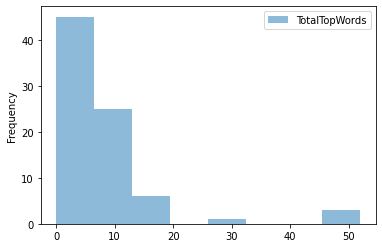

In [151]:
df_result[1][0][df_result[1][0]['annotated'] == True][['TotalTopWords']].plot.hist(bins=8, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

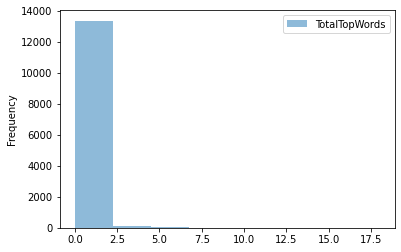

In [167]:
df_result[1][0][df_result[1][0]['annotated'] == False][['TotalTopWords']].plot.hist(bins=8, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

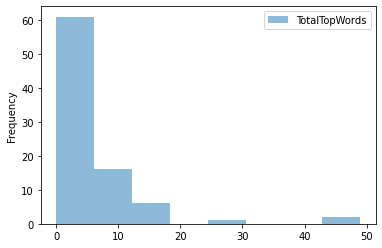

In [166]:
df_result[1][0][df_result[1][0]['annotated'] == True][['TotalTopWords']].plot.hist(bins=8, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

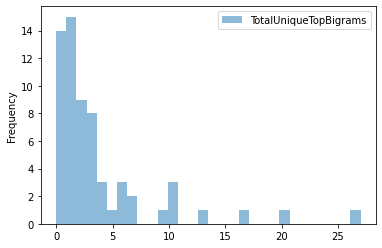

In [213]:
df_result[1][df_result[1]['annotated'] == True][['TotalUniqueTopBigrams']].plot.hist(bins=30, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

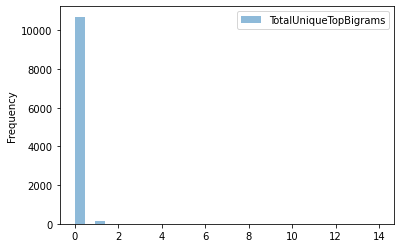

In [214]:
df_result[1][df_result[1]['annotated'] == False][['TotalUniqueTopBigrams']].plot.hist(bins=30, alpha=0.5)

In [44]:
df_result[1][1][(df_result[1][1]['annotated'] == True)

document_id  paragraph_id  page_id  page_part_id  section_id  \
11002        18974           310       13            39          20   
25258        23934           113        9             9           3   
25950        23937           180       22            21          17   
26192        23941           111       10            10           9   
26196        23941           115       10            10           9   

                                                          section_title  \
11002    CLÁUSULA 16a - DA CESSÃO, FUSÃO, INCORPORAÇÃO E SUBCONTRATAÇÃO   
25258                                        ADMINISTRAÇÃO DA SOCIEDADE   
25950  CLÁUSULA VI - REUNIÕES DE SÓCIOS. EXERCÍCIO DO DIREITO DE VOTO E   
26192  CLÁUSULA VI - REUNIÕES DE SÓCIOS, EXERCÍCIO DO DIREITO DE VOTO E   
26196  CLÁUSULA VI - REUNIÕES DE SÓCIOS, EXERCÍCIO DO DIREITO DE VOTO E   

       annotated  \
11002       True   
25258       True   
25950       True   
26192       True   
26196       True   

                                                                                                                                                                                                   text  \
11002  16.3. Não será aceito nenhuma alteração na estrutura jurídica da CONTRATADA(O) como: associação, transferência, seção total ou parcialmente em havendo prejuízo a execução do presente contrato.   
25258         (g) autorizar a execução pela Sociedade de qualquer tipo de contrato com quaisquer dos sócios, suas empresas coligadas, controladas, controladoras ou controladas por suas controladoras;   
25950                                                                                                                                                          (vi) a aprovação da exclusão de sócio; e   
26192                                                                                                                                                      (ii) a distribuição dos lucros da Sociedade;   
26196                                                                                                                                                          (vi) a aprovação da exclusão de sócio; e   

       len_sectitle_tokens  text_clusterid  perc_top_words  \
11002                    9           31940             0.0   
25258                    3           25277             0.0   
25950                   12            5564             0.0   
26192                   12            2012             0.0   
26196                   12            2018             0.0   

       perc_unique_top_words  predictions  preds_so_parag  preds_so_title  \
11002                    0.0        False           False           False   
25258                    0.0        False           False           False   
25950                    0.0        False           False           False   
26192                    0.0        False           False           False   
26196                    0.0        False           False           False   

       preds_so_tw  \
11002        False   
25258        False   
25950        False   
26192        False   
26196        False   

                                                                                                                                  parag_tokens  \
11002    [aceito, nenhuma, alteracao, estrutura, juridica, associacao, transferencia, secao, total, parcialmente, havendo, prejuizo, execucao]   
25258  [autorizar, execucao, sociedade, tipo, socios, suas, empresas, coligadas, controladas, controladoras, controladas, suas, controladoras]   
25950                                                                                                             [aprovacao, exclusao, socio]   
26192                                                                                                        [distribuicao, lucros, sociedade]   
26196                                                                                     

In [37]:
df_result[1][1][(df_result[1][1]['annotated'] == False) & (df_result[1][1]['predictions'] == True)]

document_id  paragraph_id  page_id  page_part_id  section_id  \
1355          17259          1356       55           172          19   
1666          17259          1667       67           214          19   
1691          17259          1692       68           217          19   
2277          17559            55        3             8           7   
6230          17874            28        2             5           7   
...             ...           ...      ...           ...         ...   
117204        41029           130       10            19          14   
118599        41394            35        1             2           3   
119938        41667           486       11            53           6   
119950        41667           498       11            53           6   
120027        41667           575       15            63          13   

                                                 section_title  annotated  \
1355                                   CLAUSULA CATORZE - FORO      False   
1666                                   CLAUSULA CATORZE - FORO      False   
1691                                   CLAUSULA CATORZE - FORO      False   
2277                                  CLAUSULA 4 - REMUNERAÇÃO      False   
6230    4. INEXISTÊNCIA DE VÍNCULO EMPREGATÍCIO OU SOCIETÁRIO       False   
...                                                        ...        ...   
117204         CLÁUSULA DÉCIMA SEGUNDA- - DAS CONDIÇÕES GERAIS      False   
118599                                               2. Credor      False   
119938                    - PROCESSAMENTO E COBRANÇA DA DÍVIDA      False   
119950                    - PROCESSAMENTO E COBRANÇA DA DÍVIDA      False   
120027                            - DISPOSIÇÕES COMPLEMENTARES      False   

                                                                                                                                                                                                                                                                                                                                                        text  \
1355                                                                                                                                                                                                                                                                                              Procuração que faz: ESSE PARTICTPACOES EMPRESARIAIS EIRELI   
1666                                                                                                                                                                                                                                                                           o mandato no período de 01/01/2020 a 30/04/2021 em Assembleia Geral Ordinária   
1691                                                                                                                                                                                                                                                                           o mandato no período de 01/01/2020 a 30/04/2021 em Assembleia Geral Ordinária   
2277                                                                                                                                                                                                                                                                                                      b. se 0 comprador requerer concordata ou falência;   
6230                                                                                                                                                                                                                                                                                                  4. INEXISTÊNCIA DE VÍNCULO EMPREGATÍCIO OU SOCIETÁRIO    
...                                                                                                       

In [27]:
df_result[0][['Fold', 'DataSetFrame', 'Precision', 'Recall', 'FMeasure', 'Accuracy']]
#[df_result['DataSetFrame']=='teste']

Fold DataSetFrame  Precision    Recall  FMeasure  Accuracy
0     0       treino   0.819876  0.511628  1.534884  0.971787
1     0        teste   0.182540  0.333333  1.000000  0.986379
2     1       treino   0.792746  0.595331  1.785992  0.973699
3     1        teste   0.184932  0.385714  1.157143  0.985396
4     2       treino   0.750000  0.477273  1.431818  0.967314
5     2        teste   0.206107  0.428571  1.285714  0.987128

In [80]:
list(filter(lambda x:'valor' in x,  df_result[2][0]))

[]

In [59]:
df_result[1][0][(df_result[1][0]['annotated']==False) & (df_result[1][0]['predictions']==True)][['document_id','section_id','text', 'section_title']]

document_id  section_id  \
1053          17259          19   
1117          17259          19   
1243          17259          19   
1962          17517          16   
2277          17559           7   
...             ...         ...   
119184        41402          13   
119894        41667           6   
119910        41667           6   
119934        41667           6   
119981        41667           6   

                                                                                                                                                                            text  \
1053                                                                                                                                ATA DE TRANSFORMAÇÃO DE SOCIEDADE EMPRESÁRIA   
1117                                                                                                                     Da Denominação, Sede, Filial, Objeto e Prazo de Duração   
1243                                                                       Denominação da Companhia: SOMA AMBIENTAL, TRATAMENTO E DISPOSIÇÃO DE RESIDUOS S.A. (em transformação)   
1962                                                                    12.4. O não pagamento pela CONTRATANTE dará a UNIODONTO, a seu único e exclusivo critério, o direito de:   
2277                                                                                                                          b. se 0 comprador requerer concordata ou falência;   
...                                                                                                                                                                          ...   
119184                                                                                      c) a adoção de medida judicial ou extrajudicial pela BENEFICIÁRIA contra o infrator.   
119894                                                                                                                                            9a Obriga-se a BENEFICIÁRIA a:   
119910                                                                                      f) a adoção de medida judicial ou extrajudicial pela BENEFICIÁRIA contra o infrator.   
119934  ii. restrições de acesso da BENEFICIÁRIA a novos mercados; ou iii. restrições ou prejuízo à capacidade de pagamento das obrigações financeiras decorrentes da operação.    
119981                PARÁGRAFO QUINTO: valor devido pela BENEFICIÁRIA relativo ao ECG será acrescido ao-Valor do C rédito e financiado com os Encargos praticados nesta Cédula.   

                                                         section_title  
1053                                           CLAUSULA CATORZE - FORO  
1117                                           CLAUSULA CATORZE - FORO  
1243                                           CLAUSULA CATORZE - FORO  
1962                                               12. CONTRAPRESTAÇÃO  
2277                                          CLAUSULA 4 - REMUNERAÇÃO  
...                                                                ...  
119184  CLÁUSULA DÉCIMA PRIMEIRA: OBRIGAÇÕES ESPECIAIS DA BENEFICIÁRIA  
119894                            - PROCESSAMENTO E COBRANÇA DA DÍVIDA  
119910                            - PROCESSAMENTO E COBRANÇA DA DÍVIDA  
119934                            - PROCESSAMENTO E COBRANÇA DA DÍVIDA  
119981                            - PROCESSAMENTO E COBRANÇA DA DÍVIDA  

[158 rows x 4 columns]

In [44]:
#df_parags_test[(df_parags_test['document_id'] == 10606) & (df_parags_test['section_id'] == 14)]

document_id  paragraph_id  page_id  page_part_id  section_id  \
48         10606           226        6            18          14   
829        10606           174        5            15          14   
652        10606           206        6            18          14   
46         10606           224        6            18          14   
47         10606           225        6            18          14   
49         10606           227        6            18          14   

                                           section_title  annotated  \
48   9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA       True   
829  9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA      False   
652  9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA      False   
46   9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA       True   
47   9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA       True   
49   9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA       True   

                                                                                                text  \
48                                                 lucros da empresa, de acordo com a lei 11.901/09.   
829                                              9. DAS OBRIGAÇÕES E RESPONSABILIDADES DA CONTRATADA   
652                                            dependências da execução dos serviços da CONTRATANTE.   
46   9.20. Assegurar seguro de vida em grupo e adicional de periculosidade de 30% (trinta por cento)   
47    do salário mensal sem os acréscimos resultantes de gratificações, prêmios ou participações nos   
49                9.20.1. Contrato de Seguro de Vida para os bombeiros civis deverá ser firmado pela   

     len_sectitle_tokens  text_clusterid  predictions  TruePositive  \
48                     7             262        False             0   
829                    7            6799        False             0   
652                    7            4199        False             0   
46                     7             263        False             0   
47                     7             256        False             0   
49                     7             261        False             0   

     TrueNegatives  FalsePositives  FalseNegatives  
48               0               0               1  
829              1               0               0  
652              1               0               0  
46               0               0               1  
47               0               0               1  
49               0               0               1

In [56]:
df_parags_test[(df_parags_test['annotated'] == True) & (df_parags_test['predictions'] == False)][['text', 'parag_tokens', 'sectitle_tokens', 'preds_so_parag', 'preds_so_title']].head(10)

text  \
27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      O CREDOR irá descontar o Prêmio de Seguro do empréstimo e repassar à seguradora contratada, conforme proposta de adesão de seguro, constando o CREDOR (ou o endossatário/cessionário da presente CÉDULA) como beneficiário primário.   
25                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           O EMITENTE EXPRESSAMENTE DECLARA QUE FOI INFORMADO PELO CORRESPONDENTE EPELO CREDOR QUE A CONTRATAÇÃO E LIBERAÇÃO DO EMPRÉSTIMO REPRESENTADO PELA PRESENTE CÉDULA NÃO ESTÃO VINCULADAS À CONTRATAÇÃO DO SEGURO.   
63                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 8.1.4. - Responsabilizar-se pelo seguro de seu pessoal contra risco de vida e acidentes de trabalho e/ou outro de qualquer natureza, arcando com as respectivas despesas.   
36                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         3.1.55. apresentar à ANAC, antes do início das FASES I-A e I-B, e II e na ocorrência de um novo ciclo de investimentos, a comprovação de que as apólices dos seguros exigidos na presente subseção e aplicáveis para cada uma destas fases encontram-se em vigor;   
32                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     III. Manter seguro de responsabilidade civil compatível com suas responsabilidades perante os seus funcionários, a CODESP e terceiros, e efetuar o seguro do patrimônio inerente ao CONTRATO, de 

In [66]:
df_parags_train[(df_parags_train['annotated'] == False) & (df_parags_train['predictions'] == True)].head(5)

document_id  paragraph_id  page_id  page_part_id  section_id  \
4757         9828           637       39            57           5   
4292         9828           508       30            47           5   
2852         9828           617       39            57           5   
796          9828           430       25            40           5   
2898        10362           969       45           144           9   

                                         section_title  annotated  \
4757                                        11. SEGURO      False   
4292                                        11. SEGURO      False   
2852                                        11. SEGURO      False   
796                                         11. SEGURO      False   
2898  CAPÍTULO VI - DO EQUILÍBRIO ECONÔMICO-FINANCEIRO      False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
4757                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           19|Blocos de fundações|22 dias|Sex 17/02/12 Qua 14/03/12 18CI-10 dias|||||||   
4292  A edificação será formada por modulação estrutural principal, conforme melhor ajuste ao layout a ser definido pela Prosperitas. A edificação será formada por pilares pré- moldados em concreto. Foi adotada modulação principal de 20,00m X 19,00m e pé-direito livre de 12m em toda a área de armazenagem do galpão. Na área de armazenagem interna ao galpão está previsto o fornecimento de inserts metálicos nos pré-moldados para recebimento das lajes dos mezaninos para uma sobrecarga máxima de 500kg/m² executadas em vigas metálicas e piso em chapas metálicas (as vigas e chapas metálicas não estão inclusas). A portaria terá sua estrutura em concreto pré-moldado ou moldado in-loco definido no momento de elaboração do projeto, sujeito às condições de mercado.   
2852                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       5 6 7|Finalização para anexos tecnicos para BTS Discução e assinatura do contrato|39,75 dias 39,75 dias|Ter 20/12/11 ui02/02/12 Ter 20/12/11 Qui 02/02/12|||||||   
796                                                                                                   

In [32]:
#tagg_p, mod_name = train_parg2vec_model(l_section_parag_toks, max_epochs = 300, vec_size=200, model_name ="doc2vec_unigrams.model")

Model Saved


In [93]:
#mod_name = "doc2vec_unigrams.model"
#model_d2v_unigr= Doc2Vec.load(mod_name)
#df_embb_features, feat_names = transform_to_projection(model_d2v_unigr, l_parags_ids, nfeatures =100)

In [36]:
#mod_name = "doc2vec_unigrams.model"
#model_d2v_unigr= Doc2Vec.load(mod_name)
#vec_preds = prediction_smf(l_section_parag_toks_teste, model_d2v_unigr)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
def evaluation_metrics (df, col_ann='annotated', col_pred= 'prediction'):
  
    df['TruePositive'] = df.apply(lambda x: 1 if ((x[col_ann] == True) and ((x[col_pred] == 'True'))) else 0, axis =1)
    df['TrueNegatives'] = df.apply(lambda x: 1 if ((x[col_ann] == False) and ((x[col_pred] == 'False'))) else 0, axis =1)
    df['FalsePositives'] = df.apply(lambda x: 1 if ((x[col_ann] == False) and ((x[col_pred] == 'True'))) else 0, axis =1)
    df['FalseNegatives'] = df.apply(lambda x: 1 if ((x[col_ann] == True) and ((x[col_pred] == 'False'))) else 0, axis =1)
    
    tot_truepositives, tot_truenegatives, tot_falsepositives, tot_falsenegatives = df[['TruePositive', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']].sum()
    recall = tot_truepositives/(tot_truepositives + tot_falsenegatives)
    precision = tot_truepositives/(tot_truepositives + tot_falsepositives)
    f_measure = (2*precision*recall)/precision + recall
    accuracy = (tot_truepositives + tot_truenegatives)/ (tot_truepositives + tot_truenegatives + tot_falsepositives + tot_falsenegatives)
    return precision, recall, f_measure, accuracy

In [46]:
#features_unigr = df_embb_features[feat_names]

In [49]:
#umap_3d = UMAP(n_components=3, init='random', random_state=0)
#proj_3d = umap_3d.fit_transform(features_unigr)

In [ ]:
'''
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=df_embb_features.SF_Class, labels={'color': 'SF_Class'}
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()
'''

In [ ]:
#umap_2d = UMAP(n_components=2, init='random', random_state=0)
#proj_2d = umap_2d.fit_transform(features_unigr)

In [ ]:
'''
fig_2d = px.scatter(
    proj_2d, x=0, y=1, 
    color=df_embb_features.SF_Class, labels={'color': 'SF_Class'}
)
fig_2d.update_traces(marker_size=5)
fig_2d.show()
'''

In [44]:
def tfidf_train_score(df_train, topnsims = 10):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    index_pairs = [list(df_train.index)]*cosine_sim.shape[0]
    
    # PREDICTING
    df_train['prediction_tfidfsim'] = False
    for i in range(len(index_pairs)):
        similars  = sorted(list(zip(index_pairs[i], cosine_sim[i])), key = lambda x:x[1], reverse = True)[:topnsims]
        similars = list(map(lambda x:x[0], similars))
        class_similars =df_train.iloc[similars]['annotated'].tolist()
        class_similars_cnts = Counter(class_similars)
        if (class_similars_cnts[True]>= 0.25*(class_similars_cnts[False])):
            idx_loc_score = index_pairs[i][i]
            df_train.iloc[idx_loc_score, df_train.columns.get_loc('prediction_tfidfsim')] = True
    
    return df_train, tfidf_vectorizer       

In [45]:
df_parags_train, tfidf_vectzr = tfidf_train_score(df_parags_train)

In [182]:
prec, recall, f_meas, acc = evaluation_metrics1(df_parags_train, col_pred = 'prediction_tfidfsim')
print ('------------- Metricas Treino ------------')
print ("Precision: ", prec)
print ("Recall: ", recall)
print ("F-Measue: ", f_meas)
print ("Accuracy: ", acc)
print ('------------- Metricas Treino ------------')

------------- Metricas Treino ------------
Precision:  0.2237354085603113
Recall:  0.3885135135135135
F-Measue:  1.1655405405405403
Accuracy:  0.895592485549133
------------- Metricas Treino ------------


In [172]:
def tfidf_predict (dftest, tdfidfvect_mod, topnsims = 10):
    tfidf_matrix = tdfidfvect_mod.transform(dftest['section_title'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    index_pairs = [list(dftest.index)]*cosine_sim.shape[0]
    
    # PREDICTING
    dftest['prediction_tfidfsim'] = False
    
    for i in range(len(index_pairs)):
        similars  = sorted(list(zip(index_pairs[i], cosine_sim[i])), key = lambda x:x[1], reverse = True)[:topnsims]
        similars = list(map(lambda x:x[0], similars))
        class_similars =dftest.iloc[similars]['annotated'].tolist()
        class_similars_cnts = Counter(class_similars)
        if (class_similars_cnts[True]>= 0.2*(class_similars_cnts[False])):
            idx_loc_score = index_pairs[i][i]
            dftest.iloc[idx_loc_score]['prediction_tfidfsim'] = True
    
    return dftest, tdfidfvect_mod 

In [173]:
df_parags_test, tfidf_vectzr = tfidf_predict(df_parags_test, tfidf_vectzr)

In [184]:
prec, recall,  acc = evaluation_metrics1(df_parags_test, col_pred = 'prediction_tfidfsim')
print ('------------- Metricas Test------------')
print ("Precision: ", prec)
print ("Recall: ", recall)
print ("Accuracy: ", acc)
print ('------------- Metricas Test ------------')

------------- Metricas Test------------
Precision:  0.0
Recall:  0.0
Accuracy:  0.9400590966652596
------------- Metricas Test ------------


# reformulando paragraph2vec: Bigrams + Downsample

In [99]:
l_parags_ids_bi, l_section_toks_bi, l_parags_toks_bi, l_section_parag_toks_bi = tokenize_parags_f(l_paragraph_tuples_)
l_parags_ids_bi_test, l_section_toks_bi_test, l_parags_toks_bi_test, l_section_parag_toks_bi_test = tokenize_parags_f(l_paragraph_tuples_test)

In [100]:
l_section_parag_toks_bi = remove_autosw(l_section_parag_toks_bi, ngram=2)
l_section_parag_toks_bi_test = remove_autosw(l_section_parag_toks_bi_test, ngram=2)

In [123]:
bi_tagg_p, bi_mod_name = train_parg2vec_model(l_section_parag_toks_bi, max_epochs = 200, vec_size=80, model_name ="doc2vec_bigrams.model")

Model Saved


In [124]:
model_d2v_bigr= Doc2Vec.load(bi_mod_name)
bi_vec_preds = prediction_smf(l_section_parag_toks_bi_test, model_d2v_bigr, top =5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
df_parags_test['prediction_bi'] = bi_vec_preds

In [126]:
df_parags_test[df_parags_test['prediction_bi'] == 'True'].count()

document_id            12
paragraph_id           12
page_id                12
page_part_id           12
section_id             12
section_title          12
annotated              12
text                   12
len_sectitle_tokens    12
text_clusterid         12
prediction             12
prediction_bi          12
dtype: int64

In [187]:
#model_d2v_bigr= Doc2Vec.load(bi_mod_name)
#df_embb_features, feat_names = transform_to_projection(model_d2v_bigr, l_parags_ids, nfeatures =150)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [188]:
#features_bigr = df_embb_features[feat_names]

In [189]:
#umap_3d = UMAP(n_components=3, init='random', random_state=0)
#proj_3d = umap_3d.fit_transform(features_bigr)

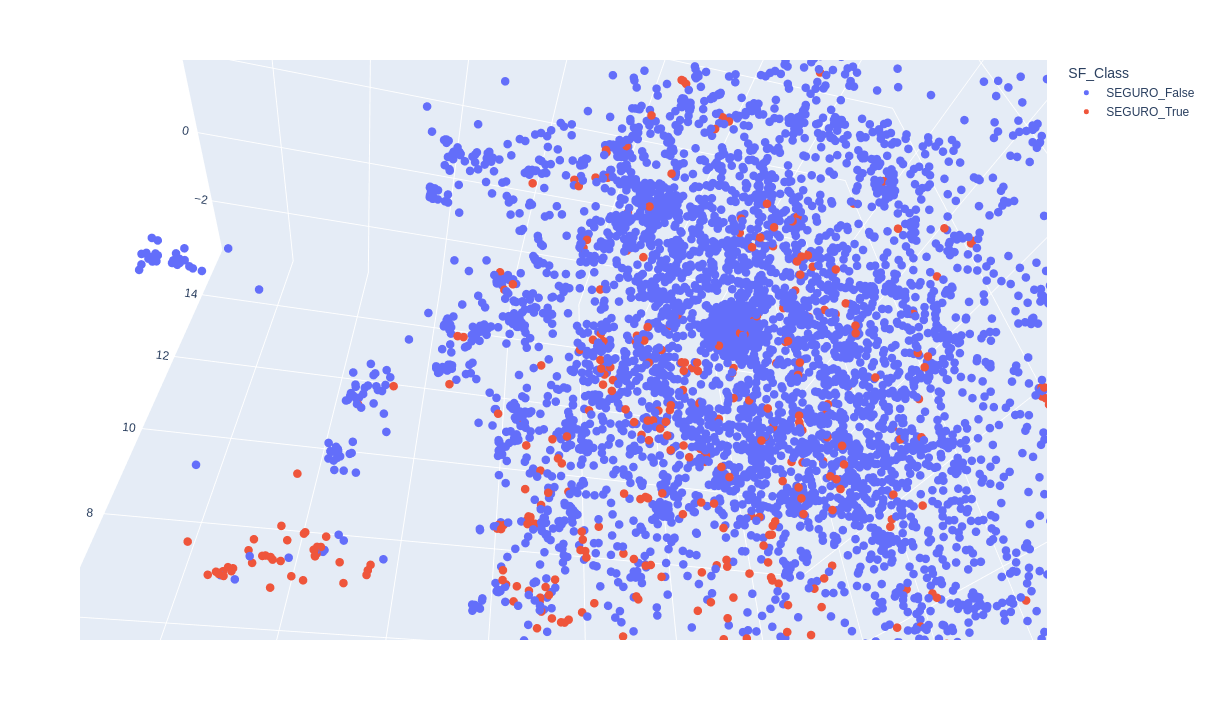

In [190]:
'''
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=df_embb_features.SF_Class, labels={'color': 'SF_Class'}
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()
'''

In [191]:
#umap_2d = UMAP(n_components=2, init='random', random_state=0)
#proj_2d = umap_2d.fit_transform(features_bigr)

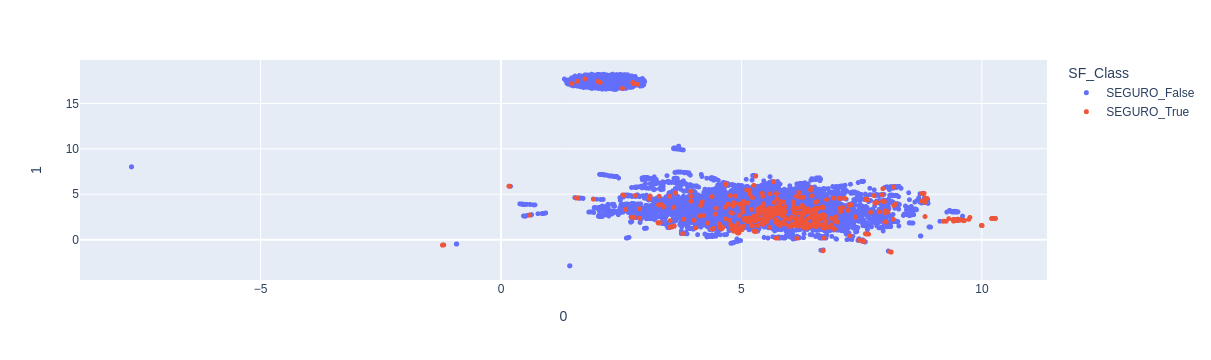

In [192]:
'''
fig_2d = px.scatter(
    proj_2d, x=0, y=1, 
    color=df_embb_features.SF_Class, labels={'color': 'SF_Class'}
)
fig_2d.update_traces(marker_size=5)

fig_2d.show()
'''

# reformulando paragraph2vec: Trigrams + Downsample

In [159]:
l_parags_ids, l_parags_toks = tokenize_parags_f(l_paragraph_tuples_, n=1)

In [160]:
l_parags_toks= remove_autosw(l_parags_toks, ngram=3)

In [161]:
l_parags_toks= remove_autosw(l_parags_toks)

In [162]:
tagg_p, mod_name = train_parg2vec_model(l_parags_toks, max_epochs = 150, vec_size=200, model_name ="doc2vec_trigrams.model")

Model Saved


In [164]:
model_d2v_trigr= Doc2Vec.load(mod_name)
df_embb_features, feat_names = transform_to_projection(model_d2v_trigr, l_parags_ids, nfeatures =150)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [165]:
features_trigr = df_embb_features[feat_names]
umap_3d = UMAP(n_components=3, init='random', random_state=0)
proj_3d = umap_3d.fit_transform(features_trigr)

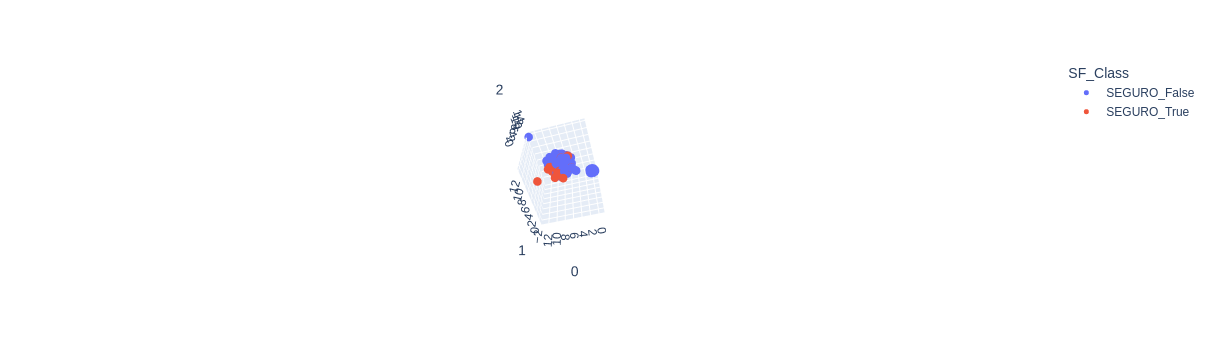

In [193]:
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=df_embb_features.SF_Class, labels={'color': 'SF_Class'}
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()

In [194]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(features_trigr)

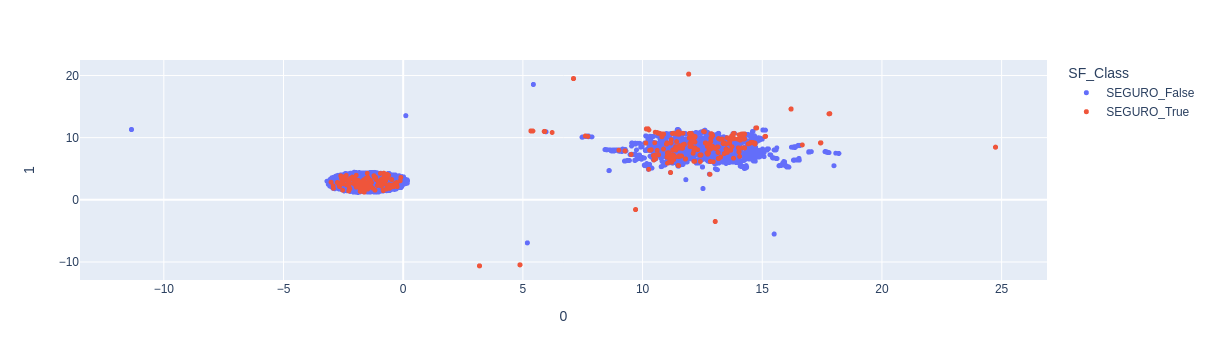

In [168]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1, 
    color=df_embb_features.SF_Class, labels={'color': 'SF_Class'}
)
fig_2d.update_traces(marker_size=5)

fig_2d.show()